# Importing libraries and loading data

In [378]:
%pip install python-metar
%pip install geopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from geopy.distance import geodesic
from metar import Metar
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from datetime import datetime, timedelta
from statistics import mode
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [380]:
bimtra_df = pd.read_csv('data/bimtra_df.csv')
esperas_df = pd.read_csv('data/esperas_df.csv')
metaf_df = pd.read_csv('data/metaf_df.csv')
metar_df = pd.read_csv('data/metar_df.csv')
tc_prev_df = pd.read_csv('data/tc-prev_df.csv')
tc_real_df = pd.read_csv('data/tc-real_df.csv')
test_data = pd.read_csv('data/idsc_test.csv')
cat_62 = pd.read_csv('data/cat-62_df.csv')

# Exploratory Analysis

In [381]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [382]:
test_data.snapshot_radar.sample(1)

60    MULTIPOINT ((-0.8904865557638337 -0.5230285423...
Name: snapshot_radar, dtype: object

In [383]:
test_data.columns

Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',
       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',
       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',
       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],
      dtype='object')

In [384]:
display(test_data.head())

display(bimtra_df.head())
display(esperas_df.head())
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(tc_prev_df.head())
display(tc_real_df.head())

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000


,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL


In [385]:
display(f'idsc_test_df: {test_data.columns}')

display(f'bimtra_df: {bimtra_df.columns}')
display(f'esperas_df: {esperas_df.columns}')
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(f'tc_prev_df: {tc_prev_df.columns}')
display(f'tc_real_df: {tc_real_df.columns}')

"idsc_test_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',\n       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',\n       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',\n       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],\n      dtype='object')"

"bimtra_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr'], dtype='object')"

"esperas_df: Index(['esperas', 'hora', 'aero'], dtype='object')"

"tc_prev_df: Index(['hora', 'troca', 'aero'], dtype='object')"

"tc_real_df: Index(['hora', 'nova_cabeceira', 'antiga_cabeceira', 'aero'], dtype='object')"

In [386]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')
print(f'cat_62: {cat_62.shape}')

bimtra_df: (48821, 5)
esperas_df: (17856, 3)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)
cat_62: (6102640, 6)


# Pre Processing

In [387]:
bimtra_df['solution'] = ((bimtra_df.dt_arr - bimtra_df.dt_dep) / 1000).astype(int)

In [388]:
bimtra_df['solution'].describe()

count    48821.000000
mean      4691.582372
std       2534.483202
min     -83541.000000
25%       2940.000000
50%       4112.000000
75%       5457.000000
max      19408.000000
Name: solution, dtype: float64

In [389]:
bimtra_df.sort_values(by='solution' ,ascending=True).head(5)

,flightid,origem,destino,dt_dep,dt_arr,solution
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541
1621,a8682cab7acc8720963b1bcf100e8e14,SBFL,SBSP,1654300317000,1654217151000,-83166
43358,8a053ceddd5cd22a111236b4975b990b,SBSP,SBCF,1658876193000,1658793794000,-82399
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133
43121,8bbeac6a115b8eed176d85126e5c4b98,SBBR,SBSP,1658876568000,1658795244000,-81324


<Axes: >

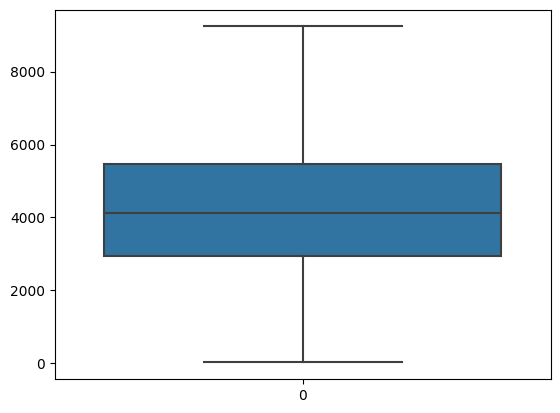

In [390]:
sns.boxplot(bimtra_df.query('solution > 0')['solution'], showfliers=False)

In [391]:
bimtra_df = bimtra_df.query('solution > 0')
q1 = bimtra_df['solution'].quantile(0.25)
q3 = bimtra_df['solution'].quantile(0.75)
iqr = q3 - q1

# Define a condition to filter outliers

condition = (bimtra_df['solution'] >= 2000) & (bimtra_df['solution'] <= q3 + 1.5*iqr + 3000)

# Apply the condition to get a DataFrame without outliers
bimtra_df = bimtra_df[condition]

In [392]:
bimtra_df['solution'].describe()

count    48502.000000
mean      4691.116201
std       2254.123029
min       2002.000000
25%       2945.000000
50%       4114.000000
75%       5444.000000
max      12223.000000
Name: solution, dtype: float64

<Axes: xlabel='solution', ylabel='Count'>

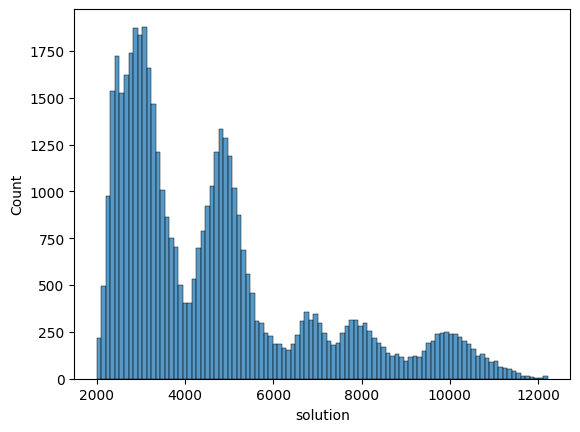

In [393]:
sns.histplot(bimtra_df['solution'], bins=100)

In [394]:
bimtra_df.query('solution < 0')

,flightid,origem,destino,dt_dep,dt_arr,solution


In [395]:
bimtra_df.dt_arr = bimtra_df.dt_arr.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
bimtra_df.dt_dep = bimtra_df.dt_dep.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
esperas_df.hora = esperas_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metaf_df.hora = metaf_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metar_df.hora = metar_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_prev_df.hora = tc_prev_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_real_df.hora = tc_real_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
test_data.hora_ref = pd.to_datetime(test_data.hora_ref)
test_data.dt_dep = pd.to_datetime(test_data.dt_dep)

In [396]:
bimtra_df['hora_ref'] = bimtra_df.dt_dep.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
bimtra_df.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00


In [397]:
tc_prev_df['aero_tcp'] = tc_prev_df['aero']
tc_prev_df = tc_prev_df.drop(['aero'], axis=1)
tc_real_df['aero_tcr'] = tc_real_df['aero']
tc_real_df = tc_real_df.drop(['aero'], axis=1)

display(tc_prev_df.head())
display(tc_real_df.head())
display(tc_real_df.shape)

,hora,troca,aero_tcp
0,2022-06-01 00:00:00,0,BR
1,2022-06-01 01:00:00,0,BR
2,2022-06-01 02:00:00,0,BR
3,2022-06-01 03:00:00,0,BR
4,2022-06-01 04:00:00,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero_tcr
0,2022-06-01 14:14:03,32,03,FL
1,2022-06-01 18:51:10,18,12,RF
2,2022-06-01 19:12:25,16,13,CF
3,2022-06-01 19:12:38,15,26,GL
4,2022-06-01 19:12:57,15,26,GL


(6167, 4)

In [398]:
tc_real_df.isna().sum()

hora                0
nova_cabeceira      0
antiga_cabeceira    0
aero_tcr            0
dtype: int64

In [399]:
esperas_df['aero_esperas'] = esperas_df['aero']
esperas_df = esperas_df.drop(['aero'], axis=1)
esperas_df['hora_esperas'] = esperas_df['hora']
esperas_df = esperas_df.drop(['hora'], axis=1)
esperas_df['hora_ref'] = esperas_df['hora_esperas'] #+ timedelta(hours=1)
esperas_df['destino'] = esperas_df['aero_esperas']

esperas_df.head()

,esperas,aero_esperas,hora_esperas,hora_ref,destino
0,0,SBBR,2022-06-01 00:00:00,2022-06-01 00:00:00,SBBR
1,0,SBBR,2022-06-01 01:00:00,2022-06-01 01:00:00,SBBR
2,0,SBBR,2022-06-01 02:00:00,2022-06-01 02:00:00,SBBR
3,0,SBBR,2022-06-01 03:00:00,2022-06-01 03:00:00,SBBR
4,0,SBBR,2022-06-01 04:00:00,2022-06-01 04:00:00,SBBR


In [400]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (48502, 7)
esperas_df: (17856, 5)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)


In [401]:
tc_real_df['hora_ref'] = tc_real_df.hora.apply(lambda x: x.replace(minute=0, second=0, microsecond=0)) 
tc_prev_df['hora_ref'] = tc_prev_df.hora #- timedelta(hours=1)

tc_real_df['hora_tcr'] = tc_real_df.hora
tc_prev_df['hora_tcp'] = tc_prev_df.hora
tc_real_df = tc_real_df.drop(['hora'], axis=1)
tc_prev_df = tc_prev_df.drop(['hora'], axis=1)

tc_real_df['destino'] = tc_real_df.aero_tcr
tc_prev_df['destino'] = tc_prev_df.aero_tcp


display(tc_real_df.head())
display(tc_prev_df.head())

,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_ref,hora_tcr,destino
0,32,03,FL,2022-06-01 14:00:00,2022-06-01 14:14:03,FL
1,18,12,RF,2022-06-01 18:00:00,2022-06-01 18:51:10,RF
2,16,13,CF,2022-06-01 19:00:00,2022-06-01 19:12:25,CF
3,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:38,GL
4,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:57,GL


,troca,aero_tcp,hora_ref,hora_tcp,destino
0,0,BR,2022-06-01 00:00:00,2022-06-01 00:00:00,BR
1,0,BR,2022-06-01 01:00:00,2022-06-01 01:00:00,BR
2,0,BR,2022-06-01 02:00:00,2022-06-01 02:00:00,BR
3,0,BR,2022-06-01 03:00:00,2022-06-01 03:00:00,BR
4,0,BR,2022-06-01 04:00:00,2022-06-01 04:00:00,BR


In [402]:
tc_prev_df['destino'] = 'SB' + tc_prev_df['destino'].astype(str)
tc_prev_df['destino'].unique()

tc_real_df['destino'] = 'SB' + tc_real_df['destino'].astype(str)
tc_real_df['destino'].unique()

tc_prev_df['aero_tcp'] = 'SB' + tc_prev_df['aero_tcp'].astype(str)
tc_prev_df['aero_tcp'].unique()

tc_real_df['aero_tcr'] = 'SB' + tc_real_df['aero_tcr'].astype(str)
tc_real_df['aero_tcr'].unique()

array(['SBFL', 'SBRF', 'SBCF', 'SBGL', 'SBSV', 'SBKP', 'SBGR', 'SBPA',
       'SBRJ', 'SBSP', 'SBBR', 'SBCT'], dtype=object)

In [403]:
train_data = pd.merge(bimtra_df, esperas_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_prev_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_real_df, how='left', on=['hora_ref', 'destino'])
# train_data['hora_ref'] = train_data['hora_ref'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [404]:
train_data.sort_values(by='solution' ,ascending=False).head(20)

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
31817,c6ee21c9f340d972df91f762a3b92370,SBSV,SBPA,2022-07-08 17:57:27,2022-07-08 21:21:10,12223,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,NaN,NaN,NaN,NaT
9812,94cba9a52482732b50b18a3969828fec,SBSV,SBPA,2022-06-12 18:42:47,2022-06-12 22:06:26,12219,2022-06-12 18:00:00,0,SBPA,2022-06-12 18:00:00,1,SBPA,2022-06-12 18:00:00,NaN,NaN,NaN,NaT
51425,582f3a20fb7ebb2a741fa213973379b4,SBSV,SBPA,2022-07-29 17:57:46,2022-07-29 21:21:21,12215,2022-07-29 17:00:00,0,SBPA,2022-07-29 17:00:00,1,SBPA,2022-07-29 17:00:00,NaN,NaN,NaN,NaT
52209,02314e4281634ee3840ed7ef79b8f685,SBSV,SBPA,2022-07-30 18:06:32,2022-07-30 21:29:49,12197,2022-07-30 18:00:00,0,SBPA,2022-07-30 18:00:00,1,SBPA,2022-07-30 18:00:00,NaN,NaN,NaN,NaT
25169,72ec4a1e747c200085d7b78ce74d5448,SBSV,SBPA,2022-06-30 17:58:59,2022-06-30 21:22:14,12195,2022-06-30 17:00:00,0,SBPA,2022-06-30 17:00:00,1,SBPA,2022-06-30 17:00:00,29,11,SBPA,2022-06-30 17:17:00
49469,00d75cc32867fe9fc6520492b8224e4d,SBSV,SBPA,2022-07-27 18:12:22,2022-07-27 21:35:22,12180,2022-07-27 18:00:00,0,SBPA,2022-07-27 18:00:00,1,SBPA,2022-07-27 18:00:00,NaN,NaN,NaN,NaT
5959,a6e0a7165193a34dad4237e650af75ac,SBSV,SBPA,2022-06-08 18:02:31,2022-06-08 21:25:17,12166,2022-06-08 18:00:00,0,SBPA,2022-06-08 18:00:00,1,SBPA,2022-06-08 18:00:00,NaN,NaN,NaN,NaT
34154,d3a2974604fd4aac214ec3af25a9c9ab,SBRF,SBSP,2022-07-10 11:31:59,2022-07-10 14:54:41,12162,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,NaN,NaN,NaN,NaT
44520,fca3feeced4fd2f5f52aa83bef0369dd,SBRF,SBSP,2022-07-21 09:24:42,2022-07-21 12:47:14,12152,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,NaN,NaN,NaN,NaT
34160,6a652367d0fb5e46a983c8183aebdadb,SBRF,SBSP,2022-07-10 09:24:27,2022-07-10 12:46:51,12144,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,35L,17L,SBSP,2022-07-10 09:10:43


In [405]:
display(train_data.sample(10))
display(train_data.shape)


,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
42217,b907abde2e908f5c936fae2a6eb3c543,SBGR,SBCF,2022-07-19 00:18:25,2022-07-19 01:07:03,2918,2022-07-19 00:00:00,0,SBCF,2022-07-19 00:00:00,0,SBCF,2022-07-19 00:00:00,NaN,NaN,NaN,NaT
21890,a599a197b241c7aa94349c548905df9d,SBFL,SBPA,2022-06-27 22:55:17,2022-06-27 23:42:27,2830,2022-06-27 22:00:00,0,SBPA,2022-06-27 22:00:00,0,SBPA,2022-06-27 22:00:00,NaN,NaN,NaN,NaT
32218,614485efd6a170b0cfb8da07a12c3de8,SBRJ,SBBR,2022-07-08 17:50:20,2022-07-08 19:22:09,5509,2022-07-08 17:00:00,0,SBBR,2022-07-08 17:00:00,0,SBBR,2022-07-08 17:00:00,NaN,NaN,NaN,NaT
40216,539c5bd9652761fc334091f43e232bb7,SBRJ,SBFL,2022-07-17 15:40:29,2022-07-17 16:54:55,4466,2022-07-17 15:00:00,0,SBFL,2022-07-17 15:00:00,1,SBFL,2022-07-17 15:00:00,21,03,SBFL,2022-07-17 15:07:27
21157,ba7d88af580b48cfbb3996ab1cf2cb46,SBFL,SBSP,2022-06-26 15:51:11,2022-06-26 16:39:12,2881,2022-06-26 15:00:00,0,SBSP,2022-06-26 15:00:00,0,SBSP,2022-06-26 15:00:00,NaN,NaN,NaN,NaT
6790,e88285beded29007d246584e917354b7,SBBR,SBGR,2022-06-09 00:21:05,2022-06-09 01:31:21,4216,2022-06-09 00:00:00,0,SBGR,2022-06-09 00:00:00,0,SBGR,2022-06-09 00:00:00,NaN,NaN,NaN,NaT
42254,4b5d325bcb1fd7ce636523135fc5cf9d,SBSP,SBFL,2022-07-19 16:33:27,2022-07-19 17:28:12,3285,2022-07-19 16:00:00,0,SBFL,2022-07-19 16:00:00,1,SBFL,2022-07-19 16:00:00,21,14,SBFL,2022-07-19 16:44:28
42282,cd2674a4db8be340d7d759fc1db8de6f,SBCT,SBSP,2022-07-19 18:41:12,2022-07-19 19:29:02,2870,2022-07-19 18:00:00,0,SBSP,2022-07-19 18:00:00,1,SBSP,2022-07-19 18:00:00,NaN,NaN,NaN,NaT
2075,9b1bf74b4fa58b2afdb21521d236dd72,SBCF,SBSP,2022-06-03 14:28:38,2022-06-03 15:31:06,3748,2022-06-03 14:00:00,0,SBSP,2022-06-03 14:00:00,1,SBSP,2022-06-03 14:00:00,NaN,NaN,NaN,NaT
53181,0d05d358fec292e37e105837a4f82451,SBGR,SBGL,2022-07-31 03:25:58,2022-07-31 04:01:30,2132,2022-07-31 03:00:00,0,SBGL,2022-07-31 03:00:00,0,SBGL,2022-07-31 03:00:00,NaN,NaN,NaN,NaT


(54767, 17)

In [406]:
train_data.isna().sum() 

flightid                0
origem                  0
destino                 0
dt_dep                  0
dt_arr                  0
solution                0
hora_ref                0
esperas                 0
aero_esperas            0
hora_esperas            0
troca                   0
aero_tcp                0
hora_tcp                0
nova_cabeceira      37301
antiga_cabeceira    37301
aero_tcr            37301
hora_tcr            37301
dtype: int64

In [407]:
train_data.shape

(54767, 17)

In [408]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


In [409]:
train_data.columns


Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'solution',
       'hora_ref', 'esperas', 'aero_esperas', 'hora_esperas', 'troca',
       'aero_tcp', 'hora_tcp', 'nova_cabeceira', 'antiga_cabeceira',
       'aero_tcr', 'hora_tcr'],
      dtype='object')

In [410]:
train_data.dt_dep, test_data.dt_dep = train_data.dt_dep.dt.hour, test_data.dt_dep.dt.hour

In [411]:
display(train_data.head())
display(test_data.head())

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


## Cat-62

In [412]:
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

print("Lowest dt_radar for each flight:")
print(lowest_lat_lon)

print("\nHighest dt_radar for each flight:")
print(highest_lat_lon)

Lowest dt_radar for each flight:
                                 flightid       lat       lon
1886448  000227eb6537e848e73cddb2e16c1cfa -0.277090 -0.835903
1403621  0003c4e7b0f7bb0c921a13aa1f13a0f8 -0.400255 -0.753191
441985   0003d070d3cddc8a27e29b0d7ec5d22e -0.400288 -0.753024
3332088  0004cef34a36fdefb955840edcd85920 -0.411467 -0.814176
4525755  0006b847a46b199088d53b7e9b1d92b0 -0.225074 -0.667812
...                                   ...       ...       ...
4519361  fffb70fc51ec80086277e97071a3f5c2 -0.225078 -0.667826
2131110  fffc340b15af31cca7e26773f155b432 -0.142195 -0.609406
422167   fffcee4a5dba0558efc39f6624432bbf -0.343052 -0.767027
1744424  fffe5e85ba343ed8d8222088fb13d2e6 -0.400262 -0.753218
2478940  ffffd0e5ce497de7ddf3d34d19b9ce3a -0.411728 -0.814580

[45911 rows x 3 columns]

Highest dt_radar for each flight:
                                 flightid       lat       lon
1886409  000227eb6537e848e73cddb2e16c1cfa -0.409024 -0.811327
1404210  0003c4e7b0f7bb0c921a13aa1f13a

In [413]:
# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid

result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')


# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df

,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-0.277090,-0.835903,-0.409024,-0.811327,14.842761
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-0.400255,-0.753191,-0.277745,-0.840381,16.664585
2,0003d070d3cddc8a27e29b0d7ec5d22e,-0.400288,-0.753024,-0.412329,-0.814326,6.952673
3,0004cef34a36fdefb955840edcd85920,-0.411467,-0.814176,-0.400477,-0.753041,6.912992
4,0006b847a46b199088d53b7e9b1d92b0,-0.225074,-0.667812,-0.408984,-0.811026,25.839791
...,...,...,...,...,...,...
45906,fffb70fc51ec80086277e97071a3f5c2,-0.225078,-0.667826,-0.408924,-0.810833,25.820023
45907,fffc340b15af31cca7e26773f155b432,-0.142195,-0.609406,-0.225272,-0.668714,11.312509
45908,fffcee4a5dba0558efc39f6624432bbf,-0.343052,-0.767027,-0.391852,-0.815442,7.626455
45909,fffe5e85ba343ed8d8222088fb13d2e6,-0.400262,-0.753218,-0.342716,-0.767360,6.554980


In [414]:
import pandas as pd
from geopy.distance import geodesic
import math

# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Convert radians to degrees for latitudes and longitudes
lowest_lat_lon['lat'] = lowest_lat_lon['lat'].apply(lambda x: math.degrees(x))
lowest_lat_lon['lon'] = lowest_lat_lon['lon'].apply(lambda x: math.degrees(x))
highest_lat_lon['lat'] = highest_lat_lon['lat'].apply(lambda x: math.degrees(x))
highest_lat_lon['lon'] = highest_lat_lon['lon'].apply(lambda x: math.degrees(x))

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid
result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')

# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df


,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-15.876090,-47.893716,-23.435326,-46.485612,849.721124
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-22.932935,-43.154675,-15.913607,-48.150257,937.304044
2,0003d070d3cddc8a27e29b0d7ec5d22e,-22.934798,-43.145079,-23.624697,-46.657456,367.372408
3,0004cef34a36fdefb955840edcd85920,-23.575327,-46.648857,-22.945616,-43.146086,365.130565
4,0006b847a46b199088d53b7e9b1d92b0,-12.895815,-38.262813,-23.433042,-46.468382,1452.970535
...,...,...,...,...,...,...
45906,fffb70fc51ec80086277e97071a3f5c2,-12.896030,-38.263632,-23.429646,-46.457283,1451.904614
45907,fffc340b15af31cca7e26773f155b432,-8.147192,-34.916419,-12.907155,-38.314484,644.566687
45908,fffcee4a5dba0558efc39f6624432bbf,-19.655459,-43.947413,-22.451487,-46.721385,423.000650
45909,fffe5e85ba343ed8d8222088fb13d2e6,-22.933333,-43.156233,-19.636165,-43.966466,374.619052


In [415]:
display(result_df.shape)
display(train_data.shape)

(45911, 6)

(54767, 17)

## METAR and METAF decoding

In [416]:
metar_df.metar = metar_df.metar.apply(lambda x: x.replace('=', ''))

metar_df['temperature_real'] = None
metar_df['dew_point_real'] = None
metar_df['wind_direction_real'] = None
metar_df['visibility_real'] = None
metar_df['wind_speed_real'] = None
metar_df['pressure_real'] = None

for i, report in enumerate(metar_df['metar']):
    try:
        report = Metar.Metar(report)
        metar_df.at[i, 'temperature_real'] = report.temp.value()
        metar_df.at[i, 'dew_point_real'] = report.dewpt.value()
        metar_df.at[i, 'wind_direction_real'] = report.wind_dir.value()
        metar_df.at[i, 'visibility_real'] = report.vis.value()
        metar_df.at[i, 'wind_speed_real'] = report.wind_speed.value()
        metar_df.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [417]:
test_data.metar = test_data.metar.apply(lambda x: x.replace('=', ''))

test_data['temperature_real'] = None
test_data['dew_point_real'] = None
test_data['wind_direction_real'] = None
test_data['visibility_real'] = None
test_data['wind_speed_real'] = None
test_data['pressure_real'] = None

for i, report in enumerate(test_data['metar']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_real'] = report.temp.value()
        test_data.at[i, 'dew_point_real'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_real'] = report.wind_dir.value()
        test_data.at[i, 'visibility_real'] = report.vis.value()
        test_data.at[i, 'wind_speed_real'] = report.wind_speed.value()
        test_data.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [418]:
test_data.metaf

0                                                   NaN
1     METAF SBRJ 190900Z  33004KT 9999       BKN033 ...
2       METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n
3     METAF SBSP 291700Z  15010KT 9999       OVC033 ...
4       METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n
                            ...                        
95    METAF SBGR 192300Z  11006KT 9000       FEW019 ...
96    METAF SBKP 312000Z  23006KT 9999       OVC022 ...
97    METAF SBRJ 201600Z  10003KT 9999       FEW033 ...
98    METAF SBSP 311200Z 07006KT 6000  - RA  OVC026 ...
99      METAF SBCT 201400Z 01002KT CAVOK 19/08 Q1020=\n
Name: metaf, Length: 100, dtype: object

In [419]:
test_data.metaf = test_data.metaf.fillna('')

In [420]:
replace_equals_newline = lambda x: x.replace('=\n', ' ')
replace_metaf = lambda x: x.replace('METAF', 'METAR')

metaf_df.metaf = metaf_df.metaf.apply(replace_equals_newline)
metaf_df.metaf = metaf_df.metaf.apply(replace_metaf)

test_data.metaf = test_data.metaf.apply(replace_equals_newline)
test_data.metaf = test_data.metaf.apply(replace_metaf)

In [421]:
metaf_df.shape

(5384, 3)

In [422]:
metaf_df['temperature_prev'] = None
metaf_df['dew_point_prev'] = None
metaf_df['wind_direction_prev'] = None
metaf_df['visibility_prev'] = None
metaf_df['wind_speed_prev'] = None
metaf_df['pressure_prev'] = None

for i, report in enumerate(metaf_df['metaf']):
    try:
        report = Metar.Metar(report)
        metaf_df.at[i, 'temperature_prev'] = report.temp.value()
        metaf_df.at[i, 'dew_point_prev'] = report.dewpt.value()
        metaf_df.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        metaf_df.at[i, 'visibility_prev'] = report.vis.value()
        metaf_df.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        metaf_df.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [423]:
test_data['temperature_prev'] = None
test_data['dew_point_prev'] = None
test_data['wind_direction_prev'] = None
test_data['visibility_prev'] = None
test_data['wind_speed_prev'] = None
test_data['pressure_prev'] = None

for i, report in enumerate(test_data['metaf']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_prev'] = report.temp.value()
        test_data.at[i, 'dew_point_prev'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        test_data.at[i, 'visibility_prev'] = report.vis.value()
        test_data.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        test_data.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [424]:
metaf_df.sample(5)

,hora,metaf,aero,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
566,2022-06-30 12:00:00,METAR SBGL 301200Z 28005KT 9999 OVC033 ...,SBGL,21.0,16.0,280.0,10000.0,5.0,1018.0
2917,2022-06-13 15:00:00,METAR SBKP 131500Z 06003KT CAVOK 19/04 Q1019,SBKP,19.0,4.0,60.0,10000.0,3.0,1019.0
4000,2022-07-31 10:00:00,METAR SBKP 311000Z 08005KT CAVOK 11/06 Q1019,SBKP,11.0,6.0,80.0,10000.0,5.0,1019.0
2337,2022-07-18 05:00:00,METAR SBGR 180500Z 12006KT 1000 BR OVC033...,SBGR,15.0,15.0,120.0,1000.0,6.0,1021.0
4236,2022-06-12 14:00:00,METAR SBSP 121400Z 33006KT 9999 FEW026 ...,SBSP,15.0,9.0,330.0,10000.0,6.0,1018.0


In [425]:
metaf_df.shape

(5384, 9)

In [426]:
metar_df['hora_ref'], metaf_df['hora_ref'] = pd.to_datetime(metar_df['hora']), pd.to_datetime(metaf_df['hora']) #- timedelta(hours=1)

In [427]:
metar_metaf = pd.merge(metar_df, metaf_df, how='left', on=['hora_ref', 'aero'])
metar_metaf.shape

(18358, 18)

In [428]:
metar_metaf['destino'] = metar_metaf['aero']
metar_metaf = metar_metaf.drop(['aero'], axis=1)

In [429]:
train_data.shape

(54767, 17)

In [430]:
metar_metaf.head()

,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_ref,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,destino
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018,21.0,8.0,70.0,10000.0,2.0,1018.0,2022-06-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019,20.0,9.0,100.0,10000.0,2.0,1019.0,2022-06-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019,16.0,9.0,0.0,10000.0,0.0,1019.0,2022-06-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019,16.0,9.0,270.0,10000.0,2.0,1019.0,2022-06-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018,14.0,9.0,0.0,10000.0,0.0,1018.0,2022-06-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR


In [431]:
train_data = pd.merge(train_data, metar_metaf, how='left', on=['hora_ref', 'destino'])

## Label Encoding

In [432]:
le = LabelEncoder()

cat_columns = ['origem', 'destino', 'aero_esperas', 'aero_tcp', 'aero_tcr']
display(train_data[cat_columns].head())
train_data[cat_columns], test_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform), test_data[cat_columns].apply(le.fit_transform)

for column in train_data.columns:
    if column == 'solution':
        continue
    if column not in test_data.columns:
        test_data[column] = 0

,origem,destino,aero_esperas,aero_tcp,aero_tcr
0,SBKP,SBRJ,SBRJ,SBRJ,NaN
1,SBGR,SBRJ,SBRJ,SBRJ,NaN
2,SBBR,SBRJ,SBRJ,SBRJ,NaN
3,SBKP,SBCF,SBCF,SBCF,NaN
4,SBCF,SBFL,SBFL,SBFL,NaN


In [433]:
train_data[cat_columns].head()

,origem,destino,aero_esperas,aero_tcp,aero_tcr
0,6,9,9,9,12
1,5,9,9,9,12
2,0,9,9,9,12
3,6,1,1,1,12
4,1,3,3,3,12


## Feature Engineering

In [434]:
train_data['rota'], test_data['rota'] = train_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1), test_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)
le.fit(train_data['rota'])
train_data['rota']= le.transform(train_data['rota'])
test_data['rota']= le.transform(test_data['rota'])

display(train_data['rota'].head())


0    60
1    56
2    10
3    18
4    15
Name: rota, dtype: int64

In [435]:
train_data['rota'].unique()

array([60, 56, 10, 18, 15, 23, 21, 27, 54, 61, 58, 19,  7,  6,  0,  5, 24,
        9, 55, 28, 62,  1, 29, 12, 41, 32, 17, 35, 47, 36,  2, 20,  3, 48,
       46,  8, 49, 22, 40, 59, 13, 14, 33, 45, 44, 39,  4, 42, 37, 51, 34,
       25, 26, 16, 53, 50, 57, 52, 30, 11, 31, 43, 38])

In [436]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,rota
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018,21.0,14.0,120.0,10000.0,6.0,1018.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,NaN,NaN,12,NaT,2022-06-01 01:00:00,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,13.0,7.0,150.0,10000.0,5.0,1021.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15


In [437]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,rota
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,11,NaN,,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,11,NaN,8,28.0,21.0,120.0,10000.0,9.0,1019.0,None,None,None,None,None,None,0,0,0,0,0,33
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,9,2023-05-19 09:00:00.000,METAR SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,9,NaN,8,19.0,17.0,20.0,10000.0,4.0,1019.0,17.0,12.0,330.0,10000.0,4.0,1020.0,0,0,0,0,0,47
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,5,2023-05-22 12:00:00.000,METAR SBGR 221200Z 04003KT CAVOK 19/09 Q1021,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022,SBGR,2023-05-22 12:00:00.000,0,5,NaN,8,13.0,12.0,70.0,10000.0,6.0,1022.0,19.0,9.0,40.0,10000.0,3.0,1021.0,0,0,0,0,0,17
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,10,2023-05-29 17:00:00.000,METAR SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,10,NaN,8,19.0,14.0,120.0,10000.0,10.0,1023.0,18.0,14.0,150.0,10000.0,10.0,1019.0,0,0,0,0,0,24
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,6,2023-05-25 23:00:00.000,METAR SBKP 252300Z 08008KT CAVOK 21/12 Q1019,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020,SBKP,2023-05-25 23:00:00.000,0,6,NaN,8,23.0,13.0,90.0,10000.0,4.0,1020.0,21.0,12.0,80.0,10000.0,8.0,1019.0,0,0,0,0,0,18


In [438]:
np.count_nonzero(train_data.rota.unique())

62

In [439]:
train_data['solution'].describe()

count    54767.000000
mean      4733.140303
std       2221.298059
min       2002.000000
25%       2987.000000
50%       4236.000000
75%       5653.500000
max      12223.000000
Name: solution, dtype: float64

In [440]:
train_data.shape

(54767, 34)

In [441]:
for column in train_data.columns:
    if train_data[column].isna().sum():
        print(column)

nova_cabeceira
antiga_cabeceira
hora_tcr
hora_x
metar
temperature_real
dew_point_real
wind_direction_real
visibility_real
wind_speed_real
pressure_real
hora_y
metaf
temperature_prev
dew_point_prev
wind_direction_prev
visibility_prev
wind_speed_prev
pressure_prev


In [442]:
columns0 = ['esperas', 'troca']
columns_mean = ['temperature_real',
'dew_point_real',
'wind_direction_real',
'visibility_real',
'wind_speed_real',
'pressure_real',
'temperature_prev',
'dew_point_prev',
'wind_direction_prev',
'visibility_prev',
'wind_speed_prev',
'pressure_prev']

In [443]:
train_data[columns0] = train_data[columns0].fillna(0)
train_data[columns_mean] = train_data[columns_mean].fillna(train_data[columns_mean].mean())

test_data[columns0] = test_data[columns0].fillna(0)
test_data[columns_mean] = test_data[columns_mean].fillna(test_data[columns_mean].mean())

In [444]:
train_data = train_data.drop(columns=['nova_cabeceira', 'antiga_cabeceira', 'dt_arr', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref', 'metar', 'metaf', 'hora_x', 'hora_y'], axis=1)
test_data = test_data.drop(columns=['snapshot_radar', 'path', 'hora_metaf', 'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref'], axis=1)

In [445]:
for column in train_data.columns:
    if column not in test_data.columns:
        print(column)

solution


In [446]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54767 entries, 0 to 54766
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flightid             54767 non-null  object 
 1   origem               54767 non-null  int64  
 2   destino              54767 non-null  int64  
 3   dt_dep               54767 non-null  int32  
 4   solution             54767 non-null  int64  
 5   esperas              54767 non-null  int64  
 6   aero_esperas         54767 non-null  int64  
 7   troca                54767 non-null  int64  
 8   aero_tcp             54767 non-null  int64  
 9   aero_tcr             54767 non-null  int64  
 10  temperature_real     54767 non-null  float64
 11  dew_point_real       54767 non-null  float64
 12  wind_direction_real  54767 non-null  float64
 13  visibility_real      54767 non-null  float64
 14  wind_speed_real      54767 non-null  float64
 15  pressure_real        54767 non-null 

## Scaling

In [447]:
scaler = StandardScaler()

# Modeling

In [448]:
train_data.shape

(54767, 23)

In [449]:
features = train_data.columns
features = features.drop(['flightid', 'solution'])
# train_data[features] = scaler.fit_transform(train_data[features])
target = 'solution'

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

In [450]:
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f'Linear Regression MSE: {mean_squared_error(y_test, y_pred)}')

# model2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# model2.fit(X_train, y_train)
# y_pred = model2.predict(X_test)
# y_pred = np.round_(y_pred)
# print(y_pred)
# print(f'Random Forest Regressor MSE: {mean_squared_error(y_test, y_pred)}')

model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)
print(y_pred)
print(f'XGBoost Regressor MSE: {mean_squared_error(y_test, y_pred)}')

[9919. 2743. 4865. ... 3182. 2868. 3714.]
XGBoost Regressor MSE: 92964.3075588826


# Submission

In [451]:
X_train, y_train = train_data[features], train_data[target]
X_test = test_data[features]
model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)

output = pd.DataFrame({'ID': test_data.flightid, 'solution': y_pred})

output.to_csv('data/submission.csv', index=False)